@Author: Ben Funk

In [10]:
# Relevant libraries
import pandas as pd
import scipy.optimize as sc
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt



In [11]:
# Load data from CSV file
file2 = pd.read_csv("../Output/LowPPMMatrix.csv")
# Extract the columns from the data
#file2=file2[file2['Target PPM']<=500]

#file2=file2[file2['Target PPM']!=150]
#file2=file2[file2['Target PPM']!=50]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

#calculate abso.lute humidity in g/m^3
P_actual_hPa = .8 * 1013.25
e_sat_standard = 6.112 * np.exp((17.67 * xDataTemp) / (xDataTemp + 243.5))
e_sat_actual = e_sat_standard * (P_actual_hPa / 1013.25)
xDataAH = 1000*((xDataRH/100)*e_sat_actual)/(461.5*(xDataTemp+ 273.15))

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


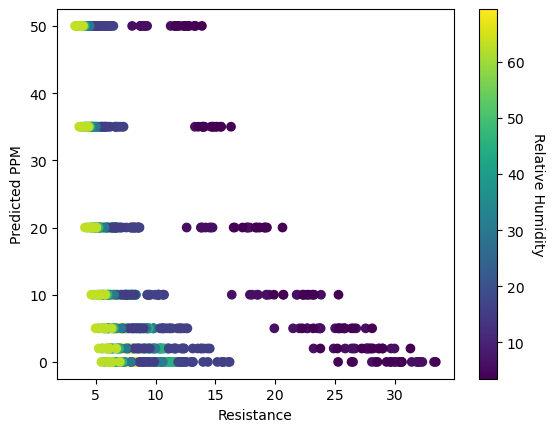

In [12]:
df = file2
# code to show data with relative humidity
scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataRH)
plt.xlabel("Resistance")
plt.ylabel('Predicted PPM')
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Humidity', rotation=270, labelpad=15)
plt.show()


# code to show data with absolute humidity
# scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataAH)
# plt.xlabel("Resistance")
# plt.ylabel('Predicted PPM')
# cbar = plt.colorbar(scatter)
# cbar.set_label('absolute', rotation=270, labelpad=15)
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 2.94632331 -0.70344483  0.04269077 -0.02934203  3.94440357 -1.58969524]
7.762713891374028


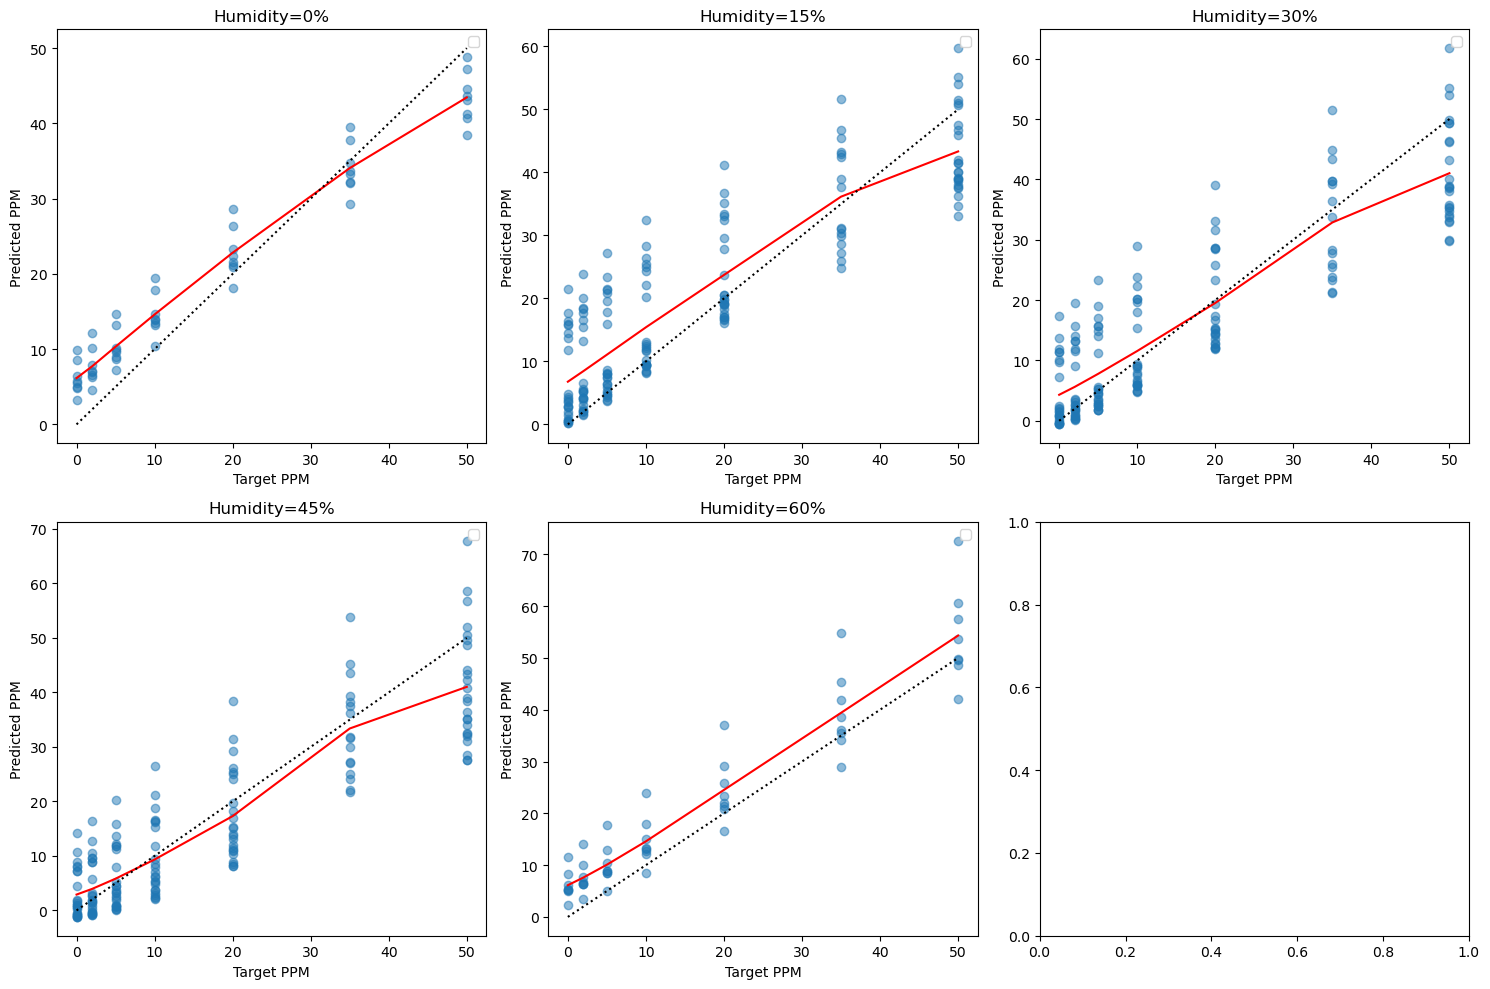

In [13]:
# Funk Equation
# a*R+b
# a*np.exp(-1*R*b+c)+d
# a*R**b+c
# a*R**b+c*H*(a*R**b+c)+d  (Basically Bastviken)
# (a*np.exp(-1*R*b+c)+d)+f*H*(a*np.exp(-1*R*b+c)+d)+g
# a*np.exp(-1*R*b+c)+d*np.exp(-1*H*f+g)+h (Funk Equation)
# a*np.exp((-1*R*b+c)+(-1*H*f+g))+h 4.2
#                                                           W/1000  W/500   UV500   UV1000
# a**((-1*R*b+c)+(-1*H*d+e))+f 6.4                          87.79   42.64   62.74   116.35
# a**((-1*R*b)+(-1*H*c)+d)+e   6.5                          87.79

# a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f 7.1                 74.09   35.76   62.37   113.46



def funkEQ(X, a, b,c,d,e,f):
    R, H = X
    with np.errstate(over='ignore'):
        stuff=a*np.exp((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f
    return stuff
p0 = 1, 1, 1, 1, 1,1

def residual(params, X, y):
    return np.sum((y - funkEQ(X, *params))**2)

# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000

popt, pcov = sc.curve_fit(funkEQ, (xDataResistance, xDataRH), yDataTargetPPM, p0, maxfev=1000000)

# Print the optimized parameters as [a b c d e f]
print(popt)

#########
# Getting RMSE of Equation
#########

R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funkEQ((R_test, H_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

#########
# All the code needed to display predicted vs actual graphs
#########

from scipy.stats import t

# Degrees of freedom
df = len(yDataTargetPPM) - len(popt)

# Student's t value for the 95% confidence level
t_val = t.ppf(1-0.05/2, df)

# Compute the standard error of the parameters
perr = np.sqrt(np.diag(pcov))

# Compute the standard error of the predictions
def predict_std(X, popt, perr):
    jac = np.array([funkEQ(X, *popt[:i], 1 if j == i else 0, *popt[i+1:]) for i,j in enumerate(range(len(popt)))]).T
    return np.sqrt(np.sum((jac * perr) ** 2, axis=1))

# Compute the 95% confidence intervals for the predicted values
predict_std_val = predict_std((R_test, H_test), popt, perr)
conf_int_lower = y_pred - t_val * predict_std_val
conf_int_upper = y_pred + t_val * predict_std_val

# break up the points by humidity percentage to show more accurate graphs
humidity_values = [0, 15, 30, 45, 60]  # Updated humidity values

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots for 5 humidities

# Flatten the axs array in case it's 2D
axs = axs.flatten()

for i, H in enumerate(humidity_values):
    # Filter the data for the given humidity value
    mask = (file2['RelativeHumidity'] >= H - 5) & (file2['RelativeHumidity'] <= H + 5)
    df_filtered = file2.loc[mask]

    xDataResistance1 = df_filtered.loc[:, 'Resistance']
    xDataRH1 = df_filtered.loc[:, 'RelativeHumidity']
    yDataTargetPPM1 = df_filtered.loc[:, 'Target PPM']

    y_pred = funkEQ((xDataResistance1, xDataRH1), *popt)
    df_filtered['Predicted PPM'] = y_pred

    # Create a scatter plot
    sc = axs[i].scatter(yDataTargetPPM1, y_pred, alpha=.5)

    # Calculate mean prediction for each target PPM and plot it
    mean_pred_per_target_ppm = df_filtered.groupby('Target PPM')['Predicted PPM'].mean()
    axs[i].plot(mean_pred_per_target_ppm.index, mean_pred_per_target_ppm.values, color='r')

    # Add a linear dotted line
    axs[i].plot(yDataTargetPPM1, yDataTargetPPM1, 'k:')

    axs[i].legend()
    axs[i].set_xlabel('Target PPM')
    axs[i].set_ylabel('Predicted PPM')
    axs[i].set_title(f'Humidity={H}%')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

#############
#Funk7.1 RMSE: 7.76      R2: 0.776       Note: Works for all humidity tested
#Funk6.5 RMSE: 10.06     R2: 0.49        Note: Does not work for 0% humidity
#Bast    RMSE: 10.12     R2: 0.57        Note: Does Terrible at 0PPM
#
#
#############

In [14]:
# Calculate residuals using the training data
residuals = yDataTargetPPM - funkEQ((xDataResistance, xDataRH), *popt)
residuals_std = np.std(residuals)

# Calculate prediction
prediction = funkEQ([15,50], *popt)

# Calculate the 95% prediction interval
prediction_interval = 1.96 * residuals_std

print("Prediction:", prediction)
print("95% Prediction Interval: [", prediction - prediction_interval, ",", prediction + prediction_interval, "]")


Prediction: -1.5607934351511927
95% Prediction Interval: [ -17.680975901122128 , 14.559389030819741 ]


R-squared:  0.7768975840975291


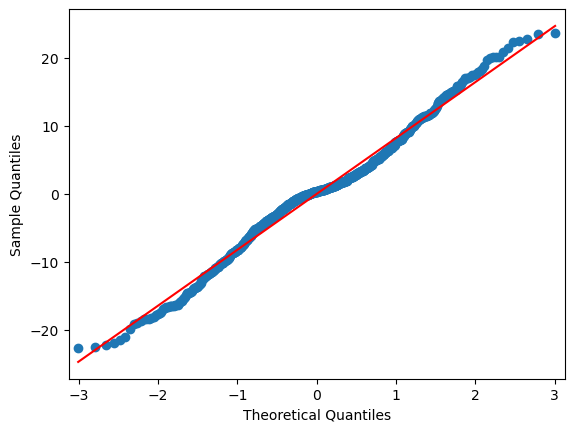

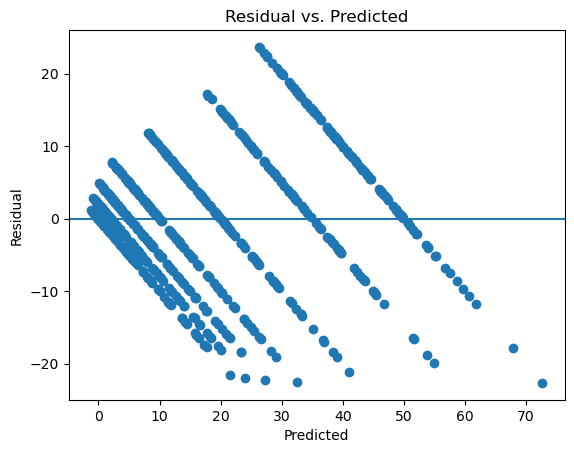

F-statistic: 519.5511625388344
p-value: 3.6664512410720497e-240


In [15]:
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = funkEQ((xDataResistance, xDataRH), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)


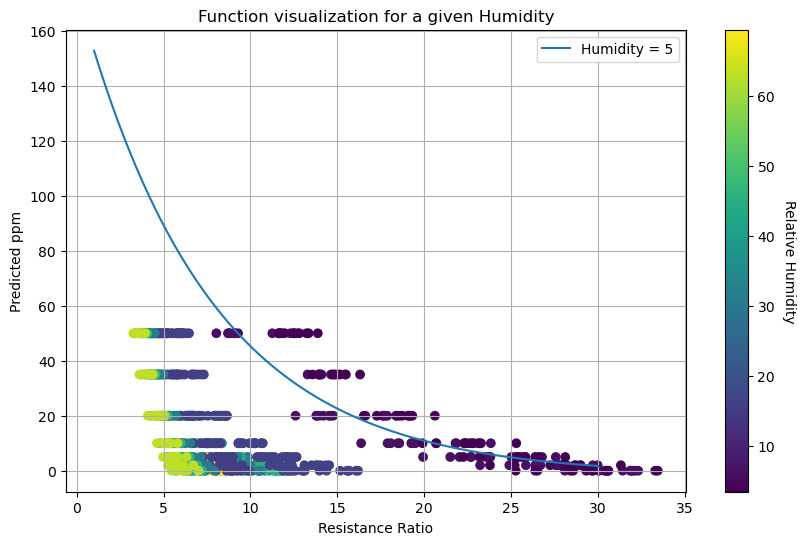

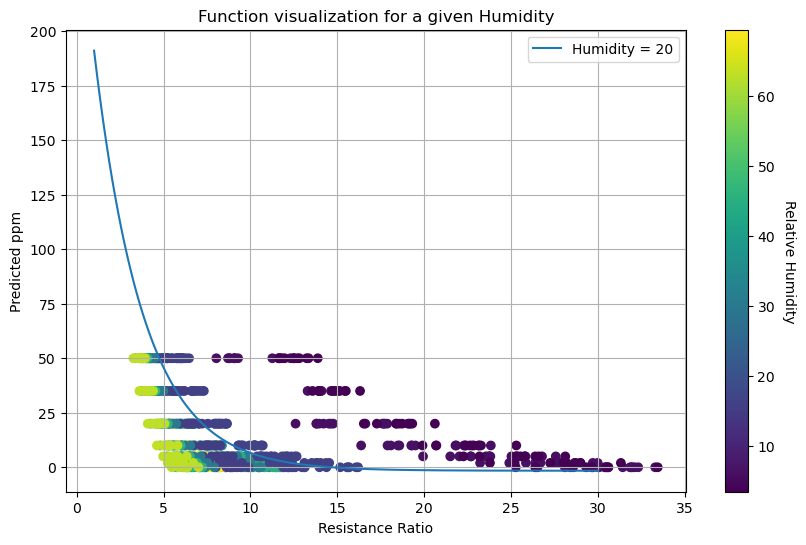

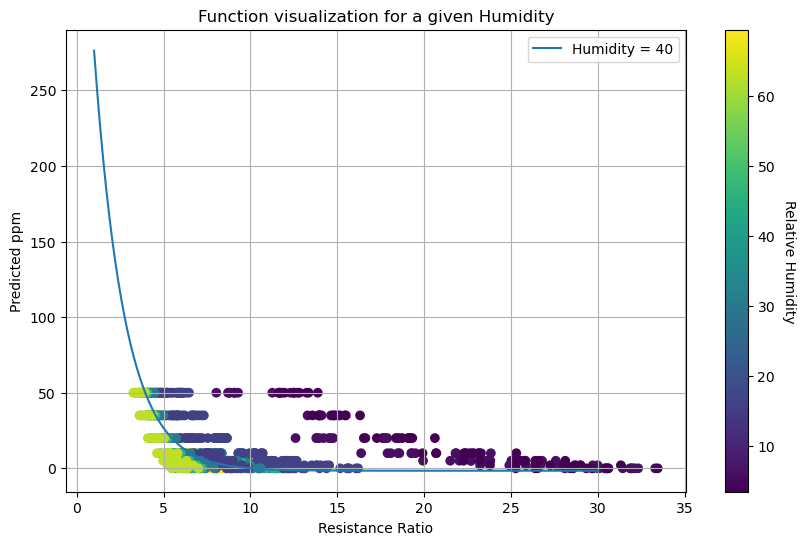

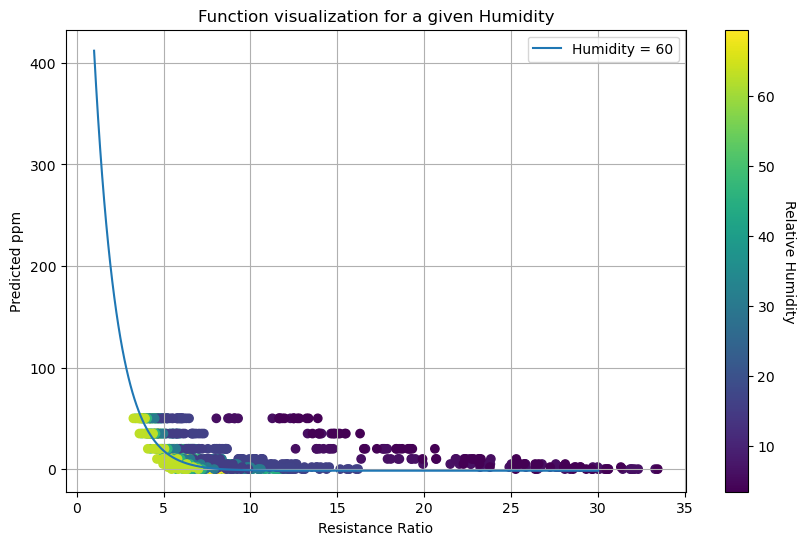

In [16]:
df=file2
# Define colors based on 'RelativeHumidity' column
colors = df.loc[:, 'RelativeHumidity']
R = np.linspace(1, 30, num=500)
for H in [5,20,40,60]:
    # calculate function values
    y_values = [funkEQ((r, H), *popt) for r in R]

    # plotting
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=colors, cmap='viridis')
    plt.plot(R, y_values, label=f'Humidity = {H}')
    plt.xlabel('Resistance Ratio')
    plt.ylabel('Predicted ppm')
    plt.title('Function visualization for a given Humidity')
    plt.legend()
    plt.grid(True)

    # Create colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Relative Humidity', rotation=270, labelpad=15)

    plt.show()
